In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3   # rgb channels of image
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)  # bcos images are in batch of 32

68

In [6]:
actual_len = 32*68
actual_len

2176

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())               # 3 denotes the rgb channel size

(32, 256, 256, 3)
[1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0]


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy)                         # every no is bw 0-255

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[140., 116., 116.],
        [135., 111., 111.],
        [107.,  85.,  87.],
        ...,
        [130., 109., 108.],
        [135., 114., 113.],
        [142., 121., 120.]],

       [[ 98.,  74.,  74.],
        [128., 104., 104.],
        [121.,  99., 101.],
        ...,
        [111.,  90.,  89.],
        [110.,  89.,  88.],
        [128., 107., 106.]],

       [[131., 107., 107.],
        [138., 114., 114.],
        [156., 134., 136.],
        ...,
        [140., 119., 118.],
        [140., 119., 118.],
        [138., 117., 116.]],

       ...,

       [[154., 142., 142.],
        [154., 142., 142.],
        [156., 144., 144.],
        ...,
        [182., 168., 167.],
        [167., 153., 152.],
        [164., 150., 149.]],

       [[160., 148., 148.],
        [160., 148., 148.],
        [160., 148., 148.],
        ...,
        [181., 167., 166.],
        [170., 156., 155.],
       

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


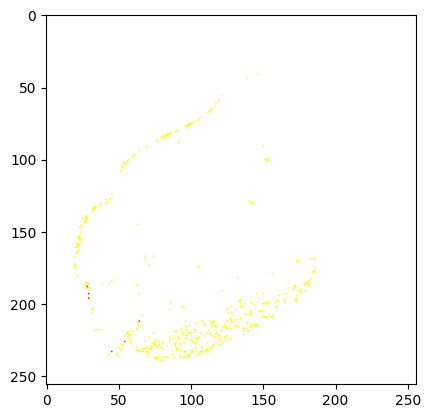

In [9]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy())       # wrong bcos this is float therefore us as type in next window

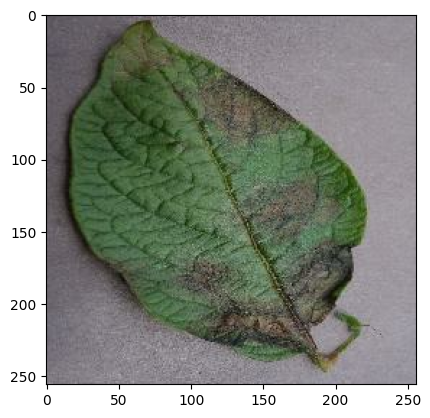

In [10]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8")) 

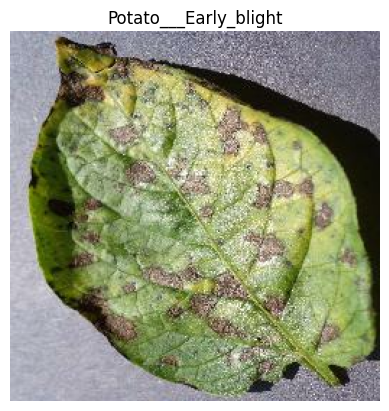

In [11]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):     ## still it will show only 1 image untill you make subplot
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.title(class_names[label_batch[i]])
        plt.axis("off")        # everytime new image bc of shufeling

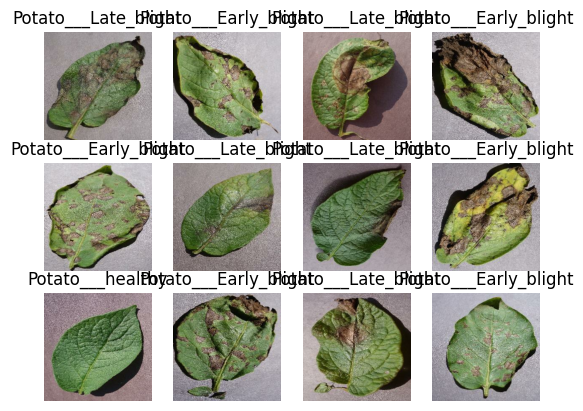

In [12]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):     ## still it will show only 1 image untill you make subplot
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.title(class_names[label_batch[i]])
        plt.axis("off")                    # now adjust area

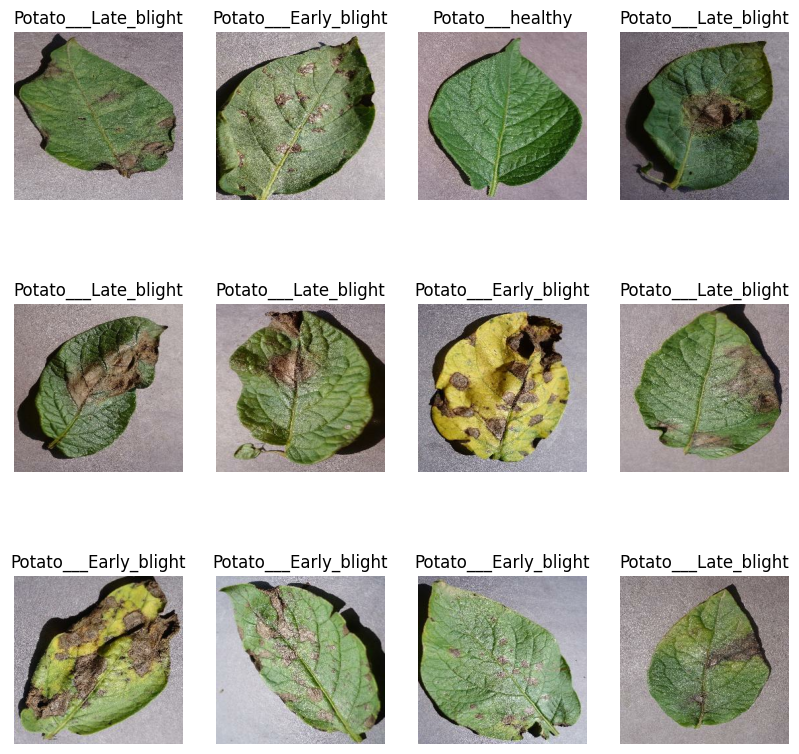

In [13]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):     ## still it will show only 1 image untill you make subplot
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.title(class_names[label_batch[i]])
        plt.axis("off") 

In [14]:
# 80% == training
# 20% == 10% validation, 10% test
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [15]:
train_ds = dataset.take(54)     # take first 54 sample of data (batches)
len(train_ds)

54

In [16]:
test_ds = dataset.skip(54)       #temporarily stor the dataset for test and train
len(test_ds)

14

In [17]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [18]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [19]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [20]:
# fn to get all of the above values
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)                                 # read about how shuffel size is selected
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)       # seed can be any no. just for predicting random no. same for every time
    
    train_size = int(ds_size*train_split)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

54

In [23]:
len(val_ds)

6

In [24]:
len(test_ds)

8

# if i want to see same photo again cache will show me,
# improve performance, dec time to load

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)                
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)   
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)   

In [26]:

# scaling is done so that i will get value 0-1 rather 0-255
# resizing is done to take care, if at the time of prediction image will not have size of 256*256 but below this,
# resizing will take care of it 
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

# data augmentation:
    i.e to inc the size of dataset we rotae the image in every direction so that our model will be robust.
    model can predict the image whether it is rotated or not

In [27]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [28]:
n_classes = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),             # all the numbers and layers are set by trial and error
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),   
    layers.Dense(n_classes, activation='softmax'),      # softmax normalize the probability of classes
    
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

i.e. 183747 are the trainable weights, that we have to train 

In [30]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 681s 12s/step - loss: 0.8972 - accuracy: 0.5110 - val_loss: 0.8133 - val_accuracy: 0.7031
Epoch 2/50
54/54 [==============================] - 559s 10s/step - loss: 0.6205 - accuracy: 0.7517 - val_loss: 0.3696 - val_accuracy: 0.8333
Epoch 3/50
54/54 [==============================] - 505s 9s/step - loss: 0.4197 - accuracy: 0.8166 - val_loss: 0.2862 - val_accuracy: 0.8698
Epoch 4/50
54/54 [==============================] - 538s 10s/step - loss: 0.3359 - accuracy: 0.8576 - val_loss: 0.2026 - val_accuracy: 0.9427
Epoch 5/50
54/54 [==============================] - 536s 10s/step - loss: 0.2389 - accuracy: 0.9039 - val_loss: 0.1492 - val_accuracy: 0.9479
Epoch 6/50
54/54 [==============================] - 526s 10s/step - loss: 0.2363 - accuracy: 0.9086 - val_loss: 0.1637 - val_accuracy: 0.9219
Epoch 7/50
54/54 [==============================] - 524s 10s/step - loss: 0.2375 - accuracy: 0.9068 - val_loss: 0.2300 - val_accuracy: 0.9167
Epoch 8

In [32]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 31s 3s/step - loss: 0.0140 - accuracy: 0.9961


In [33]:
scores

[0.013993537053465843, 0.99609375]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
history.history['accuracy']

[0.5109953880310059,
 0.7517361044883728,
 0.8165509104728699,
 0.8576388955116272,
 0.9039351940155029,
 0.9085648059844971,
 0.9068287014961243,
 0.9392361044883728,
 0.9207175970077515,
 0.9375,
 0.9438657164573669,
 0.9438657164573669,
 0.9467592835426331,
 0.9398148059844971,
 0.9542824029922485,
 0.953125,
 0.9641203880310059,
 0.9606481194496155,
 0.9675925970077515,
 0.9664351940155029,
 0.9751157164573669,
 0.9739583134651184,
 0.9814814925193787,
 0.9756944179534912,
 0.9641203880310059,
 0.9774305820465088,
 0.9739583134651184,
 0.9756944179534912,
 0.9791666865348816,
 0.9809027910232544,
 0.9762731194496155,
 0.9832175970077515,
 0.9866898059844971,
 0.9774305820465088,
 0.9809027910232544,
 0.9814814925193787,
 0.9785879850387573,
 0.9913194179534912,
 0.9820601940155029,
 0.9837962985038757,
 0.9913194179534912,
 0.9884259104728699,
 0.9855324029922485,
 0.9855324029922485,
 0.9907407164573669,
 0.9780092835426331,
 0.9918981194496155,
 0.9936342835426331,
 0.98726850748

# Plotting accuracy chart using matplotlib

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

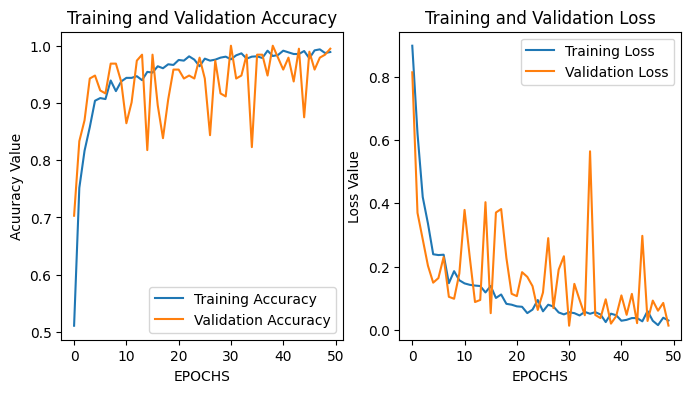

In [39]:
plt.figure(figsize = (8, 4))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('EPOCHS')
plt.ylabel('Acuuracy Value')
plt.title('Training and Validation Accuracy')


# plt.figure(figsize = (8, 8))              # otherwise it will be print below the first image
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.xlabel('EPOCHS')
plt.ylabel('Loss Value')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label:  1
first image's actual label:  Potato___Late_blight
1/1 [==============================] - 4s 4s/step
[1.6321503e-07 9.9999368e-01 6.2411623e-06]
predicted label: Potato___Late_blight


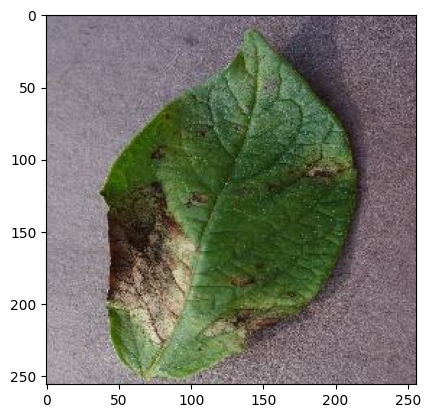

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
#     print(images_batch[0])                    # this is tensor now convert it into numpy
#     print(images_batch[0].numpy())              # lets plot
    first_image = images_batch[0].numpy().astype('uint8')
#     plt.imshow(first_image)
    first_label = labels_batch[0].numpy()
    print('first image to predict')
    plt.imshow(first_image)
    print("first image's actual label: ", first_label)
    # knowing class name also
    print("first image's actual label: ", class_names[first_label])
    # bcos model is ready
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])           # will give 3 accuracy bcos of 3 neuron in softmax, out of 3 best accuracy is class
    # index of the max value in the array is find out using np.argmax(values....)
#     print(np.argmax([0.07559327, 0.914854, 0.00955276]))
    print("predicted label:", class_names[np.argmax((batch_prediction[0]))])

# Prediction by taking image

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)    # create batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)         # round upto 2 digit given in bracket
    
    return predicted_class, confidence
    
    

1/1 [==============================] - 0s 109ms/step


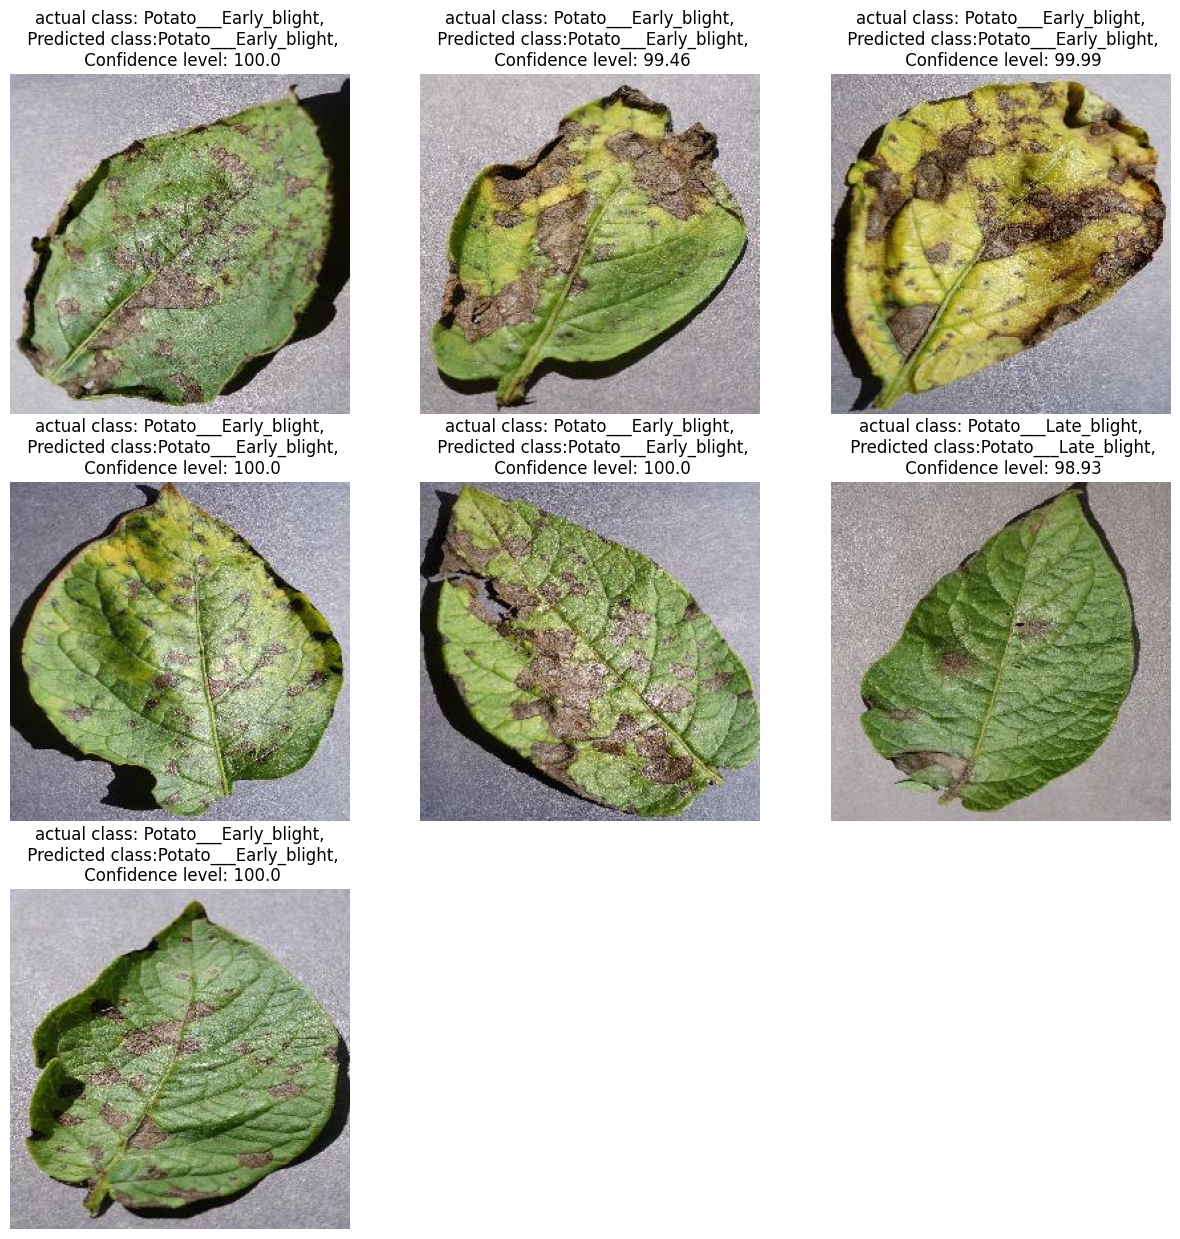

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(7):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_calss = class_names[labels[i]]
        
        plt.title(f"actual class: {actual_calss},\n Predicted class:{predicted_class},\n Confidence level: {confidence}")
        
#         axis off
        plt.axis("off")

In [43]:
# model_version = 1
# model.save(f"../models/{model_version}")       
# bcos we are inside training folder and we want to save it into models folder, thats why we have to go 2 step back by(..)

In [44]:
# to automatically save the model version no.
import os
# [os.listdir("../models/")]      # numbers of model
# converting string into int using list comprehension
moidel_version = max([int(i) for i in os.listdir("../models/") + [0]])+1
model.save(f"../saved_models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models/'